In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp
import matplotlib.pyplot as plt

np.random.seed(1234)
# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)
table = table_min.merge(table_sum, on=index,how='left')
table

# Selling & Buying & Rating & Probability of buying
product_category = ['computers_accessories']

selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

# we set the margin as a uniform % 
buying = {}
for category in product_category:
    buying[category] = selling[category] * np.random.uniform(0.6,0.7, size = len(selling[category]))


rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum())

weights = {}
for category in product_category:
    weights[category] = (table.loc[category]['product_weight_g'].values)

softmax={}
for category in product_category:
    softmax[category] = (np.exp(-selling[category]*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-selling[category]*(MAX_RATING - rating[category])/100)))

prop_customers = softmax['computers_accessories']
max_customers = n_customers['computers_accessories'] *prop_customers

print("Buying prices ", buying)
print("RRP ", selling)
print("Product ratings ", rating)
print("Weights ", weights)

Buying prices  {'computers_accessories': array([41.07586679, 51.58622733, 85.60246575, 77.68635332, 52.31090335,
       94.02616315])}
RRP  {'computers_accessories': array([ 66.34214286,  77.9       , 132.97      , 114.4911538 ,
        77.155     , 149.9       ])}
Product ratings  {'computers_accessories': array([4. , 3.5, 4.2, 4.2, 3.5, 4.3])}
Weights  {'computers_accessories': array([ 173,  180,  922, 6550,  207,  533])}


Text(0, 0.5, 'Max Number of Customers to Buy')

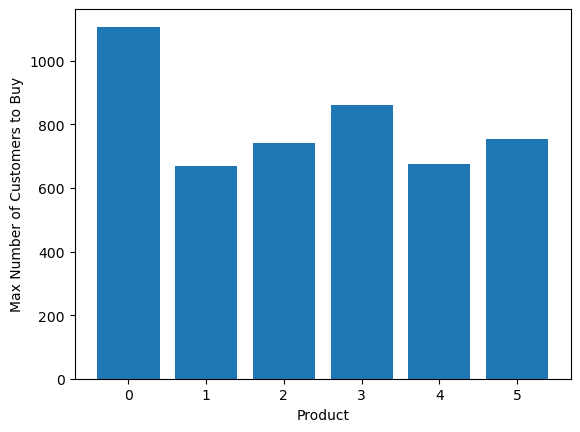

In [2]:
plt.bar(np.arange(6), max_customers)
plt.xlabel("Product")
plt.ylabel("Max Number of Customers to Buy")

In [3]:
# fixed freight cost, can change if needed
SHIPPING_COST = 0

# how many customers we have that won't buy unless extra conditions are fufilled
MARKET_CUSTOMERS = {category: 10000 for category in product_category}

# what % of 'market' customers do we get for each % of discount?
DISCOUNT_FACTOR = 0

# what % of 'market' customers do we get if we have free shipping
FREE_SHIPPING_FACTOR = 0

# the budget
BUDGET = 1e6

# inventory for each category, we will set this to be a proportion of the number of customers
INVENTORY_SPACE = n_customers['computers_accessories'] * 0.75

BULK_PURCHASE_COST = 1e3
BULK_WEIGHT = 1e4

In [4]:
def run_model():
    m = gp.Model()

    BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    stock = {}
    is_chosen = {}
    sold = {}
    discount = {}
    free_shipping = {}
    transport_multiplier = {}
    vars = {
        'stock':stock, 'is_chosen':is_chosen, 'sold':sold, 'discount':discount, 'free_shipping':free_shipping,
    }

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        stock[category] = m.addVars(I,vtype = GRB.INTEGER)
        is_chosen[category] = m.addVars(I, vtype = GRB.BINARY)
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)
        transport_multiplier[category] = m.addVar(vtype = GRB.INTEGER)

    # amount sold and extra customers
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i])
    )
    amount_sold  = lambda category,i: softmax[category][i]* (n_customers[category] + captured_customers(category,i))

    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - stock[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST * free_shipping[category][i]
                    for i in range(len(selling[category]))) 
                    - BULK_PURCHASE_COST * transport_multiplier[category] for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstrs( gp.quicksum(stock[category][i] for i in range(len(selling[category]))) <= INVENTORY_SPACE 
                for category in product_category)

    # Can't buy more than the budget
    m.addConstr(gp.quicksum( gp.quicksum(stock[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category) <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        m.addConstrs(stock[category][i] <= is_chosen[category][i] * BIGNUM
                    for i in range(len(selling[category])))
        # Can't sell more than you have stocked
        m.addConstrs(sold[category][i] <= stock[category][i] for i in range(len(selling[category])))
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                    for i in range(len(selling[category])))
        m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))
        m.addConstrs(transport_multiplier[category] >= (1 / BULK_WEIGHT) * gp.quicksum(stock[category][i] * weights[category][i]
                                                                    for i in range(len(selling[category])))
                                                                    for category in product_category)

    m.params.NonConvex = 2
    m.optimize()
    data = {}
    for category in product_category:
        data[category] = {}
        for v in vars:
            data[category][v] = [a.X for a in vars[v][category].values()]
        data[category]['transport_units'] = transport_multiplier[category].X

    return m,data


In [5]:
( selling['computers_accessories']- buying['computers_accessories'] ) / buying['computers_accessories']

array([0.61511243, 0.51009298, 0.55334311, 0.47376146, 0.47493152,
       0.59423712])

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 27 rows, 31 columns and 49 nonzeros
Model fingerprint: 0x8bbe656d
Model has 6 quadratic objective terms
Variable types: 6 continuous, 25 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e+01, 1e+02]
  QObjective range [1e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 26 rows and 26 columns
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros
Variable types: 0 continuous, 5 integer (0 binary)
Found heuristic solution: objective 12290.948695

Root relaxation: objective 1.230147e+04, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    

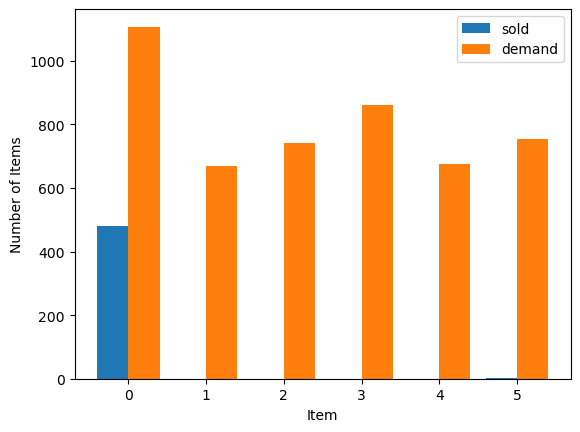

In [24]:
BUDGET = 2e4

# inventory for each category, we will set this to be a proportion of the number of customers
INVENTORY_SPACE = 10000

BULK_PURCHASE_COST = 0
BULK_WEIGHT = 1
m,data = run_model()
# the budget

sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 27 rows, 31 columns and 49 nonzeros
Model fingerprint: 0xbc503d2b
Model has 6 quadratic objective terms
Variable types: 6 continuous, 25 integer (12 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  Objective range  [4e+01, 1e+03]
  QObjective range [1e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 25 rows and 25 columns
Presolve time: 0.00s
Presolved: 2 rows, 6 columns, 11 nonzeros
Variable types: 0 continuous, 6 integer (0 binary)

Root relaxation: objective 3.877594e+03, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

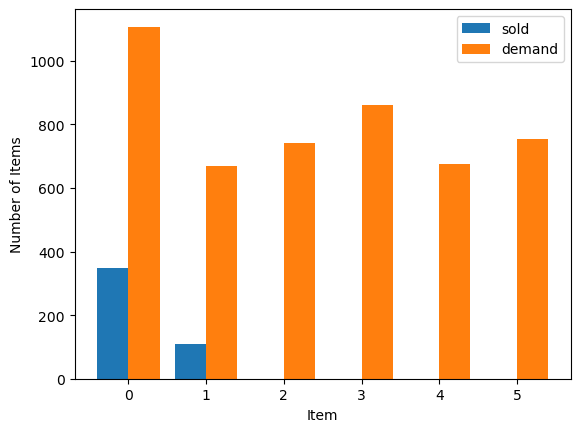

In [26]:
BUDGET = 2e4

# inventory for each category, we will set this to be a proportion of the number of customers
INVENTORY_SPACE = 10000

BULK_PURCHASE_COST = 1e3
BULK_WEIGHT = 1e4
m,data = run_model()
# the budget

sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))

In [27]:
data

{'computers_accessories': {'stock': [349.0, 109.0, -0.0, -0.0, -0.0, -0.0],
  'is_chosen': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'sold': [349.0, 109.0, 0.0, 0.0, 0.0, 0.0],
  'discount': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'free_shipping': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'transport_units': 8.0}}